# Actividad 2 - Clasificación
# Universidad Europea de Madrid
Inteligencia Artificial<br>
Isabel Sutil<br>
M31<br>
Jorge Javier Castilla Coello<br>
Geronimo Basso Sosa<br>
Luis Cabello Casquete<br>
Paula Sáenz de Santa María Diez<br>
Ana Esteban González<br>




# Codigo en común utilizado por todos los apartados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.base import clone
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import make_scorer

# Apartado 0
Modificar el dataset para que cada vez que en "prec" se encuente el valor 0,0 se considere que no llueve, para los demas valores se va a considerar que si ha llovido

In [2]:
# Cargar el fichero necesario para analizar el modelo.
ruta_archivo = 'valores-climatologicos.csv'
dataframe = pd.read_table(ruta_archivo, sep=',')

# Utilizar una función lambda: para cada valor de 'prec', asignar 'YES' si la precipitación es mayor que 0, 'NO' en caso contrario.
# Además, crear un mapeo de indicativos de provincia para tener valores de tipo int en esa columna en vez de strings.
dataframe['prec'] = dataframe['prec'].apply(lambda x: 'YES' if x > 0 else 'NO')
states = ['1387E', '1387', '1393', '1351', '1400', '1437O', '1473A', '1428', '1475X', '1505', '1484', '1484C', '1495']
state_map = {state: idx for idx, state in enumerate(sorted(set(states)))}
dataframe['indicativo'] = dataframe['indicativo'].apply(lambda x: state_map[x])

# Crear un dataset específico con valores de tipo float para que los modelos puedan entrenar mejor.
# dataframe = dataframe.astype(float)
columns_to_convert = ['indicativo', 'altitud', 'tmed', 'tmin', 'tmax', 'dir', 'velmedia', 'racha', 'presMax', 'presMin']

# Convertir cada columna especificada a tipo float
for column in columns_to_convert:
    dataframe[column] = dataframe[column].astype(float)

# Convertir la columna 'prec' de tipo float a 'categorical'
dataframe['prec'] = pd.Categorical(dataframe['prec'])

# Imprimir el dataframe resultante
print(dataframe)

       indicativo  altitud  tmed prec  tmin  tmax   dir  velmedia  racha  \
0             2.0     98.0  16.9   NO  12.0  21.8   1.0       3.1    8.3   
1             2.0     98.0  20.5  YES  12.5  28.5  22.0       4.7   11.7   
2             2.0     98.0  21.4   NO  17.6  25.1  22.0       2.2   10.3   
3             2.0     98.0  21.4  YES  16.0  26.8  99.0       5.3   10.8   
4             2.0     98.0  18.6   NO  15.7  21.6   4.0       3.9   11.7   
...           ...      ...   ...  ...   ...   ...   ...       ...    ...   
11531        11.0    255.0  12.2   NO   5.5  18.8   8.0       1.7    9.7   
11532        11.0    255.0  11.2  YES   5.4  16.9  99.0       3.6    8.3   
11533        11.0    255.0   9.8  YES   6.4  13.1  27.0       1.7    7.2   
11534        11.0    255.0  11.7   NO   7.5  15.9  19.0       1.9    6.7   
11535        11.0    255.0  10.6  YES   8.7  12.6  20.0       5.0   13.9   

       presMax  presMin  
0       1008.7   1003.9  
1       1008.5   1005.5  
2       1

# Apartado 4
Análisis predictivo con un árbol de decisión

# Crear el dataset de entrenamieno y validación, y además crear el cross validation.

In [3]:
# Separar las características (features) y la variable de salida (target)
X = dataframe.drop('prec', axis=1)  # Features
y = dataframe['prec']  # Variable de salida

# División en 80/20 para entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:", len(X_val))

# Crear conjuntos de entrenamiento y prueba
conjunto_train = pd.concat([X_train, y_train], axis=1)  # Conjunto de entrenamiento con características y variable de salida
conjunto_val = pd.concat([X_val, y_val], axis=1)  # Conjunto de validación con características y variable de salida

# Crear conjuntos adicionales para almacenar las predicciones del conjunto de entrenamiento y validación
conjunto_train_eval = conjunto_train.copy()
conjunto_validation_eval = conjunto_val.copy()

Tamaño del conjunto de entrenamiento: 9228
Tamaño del conjunto de validación: 2308


In [4]:
# Inicializar diccionarios para almacenar las precisiones en conjuntos de entrenamiento y validación
precision_train = {}  # Diccionario para almacenar precisiones en el conjunto de entrenamiento
precision_val = {}    # Diccionario para almacenar precisiones en el conjunto de validación

In [5]:
# Método de control (k-fold cross-validation)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Train

In [6]:
# Definir el clasificador de árbol de decisiones
dt_classifier = DecisionTreeClassifier()

# Definir un rango de valores para ccp_alpha (parámetro de complejidad) que se probarán durante la búsqueda de la cuadrícula
alpha_range = [i * 0.0005 for i in range(11)]

# Definir los parámetros que deseas ajustar mediante búsqueda de cuadrícula
param_grid = {
    'ccp_alpha': np.arange(0, 0.1, 0.0005),          # Parámetro de penalización de complejidad del árbol
    'min_samples_split': [2, 5, 10],                  # Número mínimo de observaciones en el nodo para dividir
    'min_samples_leaf': [1, 5, 10],                   # Número mínimo de observaciones en el nodo hoja
    'criterion': ['gini', 'entropy']                  # Criterio de impureza para la función de división
}

In [7]:
# Definir la métrica de evaluación (Accuracy)
scorer = make_scorer(accuracy_score)

# Configurar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(dt_classifier, param_grid, scoring=scorer, cv=cv)

In [8]:
# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Imprimir resultados
print("Mejor modelo:", best_model)

Mejor modelo: DecisionTreeClassifier(ccp_alpha=0.0005, min_samples_leaf=10)


In [9]:
# Realizar predicciones en el conjunto de entrenamiento utilizando el mejor modelo seleccionado
y_val_pred = best_model.predict(X_train.values)

# Calcular la precisión en el conjunto de entrenamiento comparando las predicciones con las etiquetas reales
accuracy_train = accuracy_score(y_train, y_val_pred)

# Imprimir la precisión en el conjunto de entrenamiento
print("Precisión en el conjunto de entrenamiento:", accuracy_train)

Precisión en el conjunto de entrenamiento: 0.8062418725617685


/Users/geronimobasso/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [10]:
# Realizar predicciones en el conjunto de entrenamiento utilizando el mejor modelo seleccionado
y_train_pred = best_model.predict(X_train)

# Calcular la matriz de confusión en el conjunto de entrenamiento
confusion_mat_train = confusion_matrix(y_train, y_train_pred)

# Imprimir la matriz de confusión y la precisión en el conjunto de entrenamiento
print("Matriz de Confusión (Train):")
print(confusion_mat_train)


Matriz de Confusión (Train):
[[3787  882]
 [ 906 3653]]


In [11]:
# Obtener los resultados del grid search y almacenarlos en un DataFrame
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Imprimir información sobre cada fold en la validación cruzada
for fold in range(10):  # Número de splits en la validación cruzada
    fold_column = f'split{fold}_test_score'
    
    print(f"Información para el Fold {fold + 1}:")
    
    # Imprimir el mejor valor de ccp_alpha y la precisión en el fold correspondiente
    print(f"  Mejor valor de ccp_alpha: {resultados_df['param_ccp_alpha'][resultados_df[fold_column].idxmax()]}")
    print(f"  Precisión en el fold: {resultados_df[fold_column].max()}")
    
    print("\n")


Información para el Fold 1:
  Mejor valor de ccp_alpha: 0.0015
  Precisión en el fold: 0.7703141928494042


Información para el Fold 2:
  Mejor valor de ccp_alpha: 0.001
  Precisión en el fold: 0.7757313109425785


Información para el Fold 3:
  Mejor valor de ccp_alpha: 0.0005
  Precisión en el fold: 0.7648970747562297


Información para el Fold 4:
  Mejor valor de ccp_alpha: 0.0015
  Precisión en el fold: 0.7789815817984832


Información para el Fold 5:
  Mejor valor de ccp_alpha: 0.001
  Precisión en el fold: 0.8017334777898159


Información para el Fold 6:
  Mejor valor de ccp_alpha: 0.0005
  Precisión en el fold: 0.7963163596966414


Información para el Fold 7:
  Mejor valor de ccp_alpha: 0.0005
  Precisión en el fold: 0.7865655471289275


Información para el Fold 8:
  Mejor valor de ccp_alpha: 0.001
  Precisión en el fold: 0.8039003250270856


Información para el Fold 9:
  Mejor valor de ccp_alpha: 0.0005
  Precisión en el fold: 0.7603036876355749


Información para el Fold 10:
  

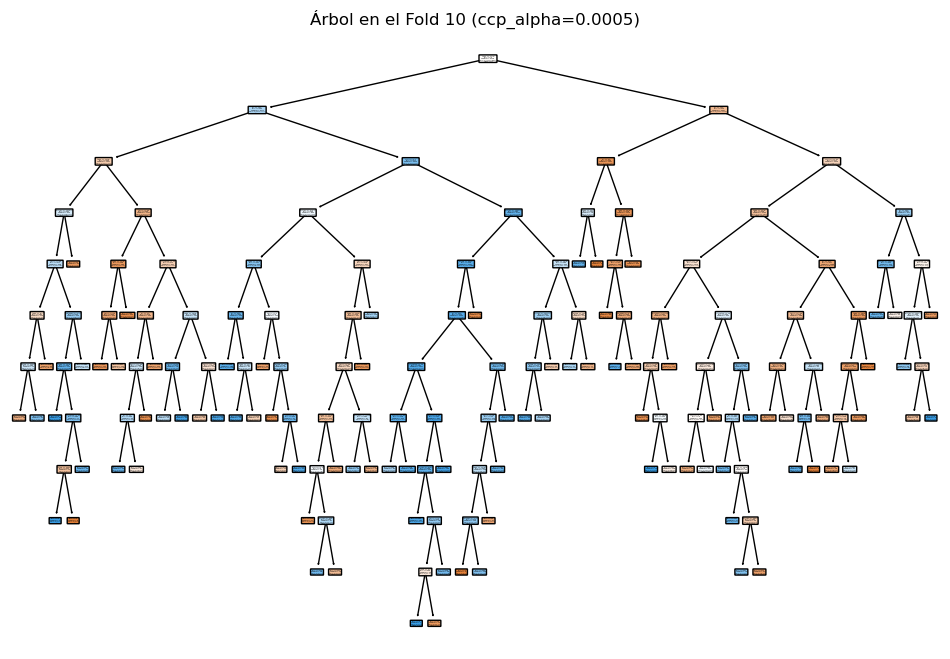

In [12]:
from sklearn.tree import plot_tree

# Obtener los resultados del grid search y almacenarlos en un DataFrame
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Iterar sobre los splits y visualizar los árboles
for fold in range(10):  # Ajusta esto según el número de splits en tu validación cruzada
    fold_column = f'split{fold}_test_score'
    
    # Obtener el mejor valor de ccp_alpha en el fold actual
    best_alpha = resultados_df['param_ccp_alpha'][resultados_df[fold_column].idxmax()]

    # Crear y entrenar un árbol con el mejor ccp_alpha en el fold actual
    tree_model = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=150)
    tree_model.fit(X_train, y_train)

# Visualizar el árbol

# Crear una nueva figura con dimensiones específicas para la visualización del árbol
plt.figure(figsize=(12, 8))

# Utilizar la función plot_tree de scikit-learn para visualizar el árbol entrenado
# - 'tree_model': el modelo de árbol de decisiones que acabamos de entrenar
# - 'filled=True': colorea los nodos del árbol según la clase mayoritaria para mayor claridad
# - 'feature_names': proporciona nombres de características para etiquetar los nodos del árbol
# - 'class_names': proporciona nombres de clases ('NO' y 'YES') para etiquetar las hojas del árbol
# - 'rounded=True': redondea las cajas de los nodos para una apariencia más estética
plot_tree(tree_model, filled=True, feature_names=['indicativo', 'altitud', 'tmed', 'tmin', 'tmax', 'dir', 'velmedia', 'racha', 'presMax', 'presMin'], class_names=['NO', 'YES'], rounded=True)

# Establecer el título de la figura con información sobre el fold actual y el valor de ccp_alpha utilizado
plt.title(f"Árbol en el Fold {fold + 1} (ccp_alpha={best_alpha})")

# Mostrar la figura que contiene la visualización del árbol
plt.show()


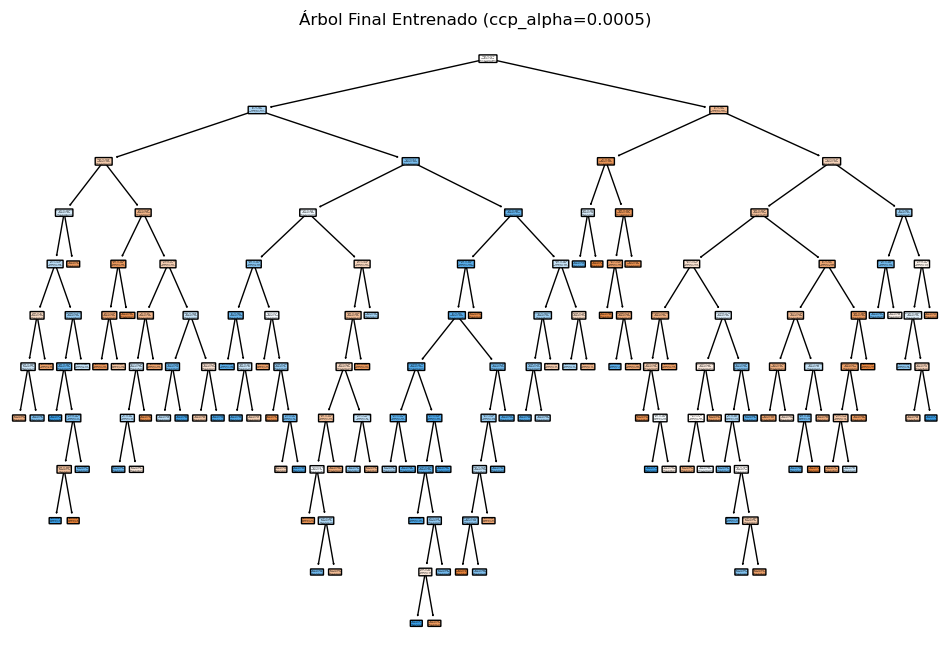

In [13]:
# Visualizar el árbol final entrenado con el mejor ccp_alpha

# Obtener el mejor valor de ccp_alpha de los parámetros óptimos encontrados durante la búsqueda de cuadrícula
best_alpha_final = grid_search.best_params_['ccp_alpha']

# Crear y entrenar un árbol de decisiones con el mejor ccp_alpha en todo el conjunto de entrenamiento
final_tree_model = DecisionTreeClassifier(ccp_alpha=best_alpha_final, random_state=150)
final_tree_model.fit(X_train, y_train)

# Crear una nueva figura con dimensiones específicas para la visualización del árbol final
plt.figure(figsize=(12, 8))

# Utilizar la función plot_tree de scikit-learn para visualizar el árbol final entrenado
# - 'filled=True': colorea los nodos del árbol según la clase mayoritaria para mayor claridad
# - 'feature_names': proporciona nombres de características para etiquetar los nodos del árbol
# - 'class_names': proporciona nombres de clases ('NO' y 'YES') para etiquetar las hojas del árbol
# - 'rounded=True': redondea las cajas de los nodos para una apariencia más estética
plot_tree(final_tree_model, filled=True, feature_names=['indicativo', 'altitud', 'tmed', 'tmin', 'tmax', 'dir', 'velmedia', 'racha', 'presMax', 'presMin'], class_names=['NO', 'YES'], rounded=True)

# Establecer el título de la figura con información sobre el árbol final y el valor de ccp_alpha utilizado
plt.title(f"Árbol Final Entrenado (ccp_alpha={best_alpha_final})")

# Mostrar la figura que contiene la visualización del árbol final
plt.show()


In [14]:
# Obtener el mejor modelo después de la búsqueda de hiperparámetros
best_model = grid_search.best_estimator_

# Obtener la importancia de las variables
importances = best_model.feature_importances_

# Crear un DataFrame para visualizar la importancia de las variables
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Ordenar el DataFrame por importancia en orden descendente
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Imprimir la importancia de las variables
print("Importancia de las variables:")
print(importances_df)

Importancia de las variables:
      Feature  Importance
4        tmax    0.346380
5         dir    0.269006
7       racha    0.143328
3        tmin    0.090054
9     presMin    0.076583
0  indicativo    0.028342
1     altitud    0.021771
8     presMax    0.016896
6    velmedia    0.007640
2        tmed    0.000000


# VALIDATION

In [15]:
# Evaluar el modelo en el conjunto de evaluación

# Realizar predicciones en el conjunto de evaluación utilizando el mejor modelo seleccionado
y_val_pred = best_model.predict(X_val)

# Calcular la precisión en el conjunto de evaluación comparando las predicciones con las etiquetas reales
accuracy_val = accuracy_score(y_val, y_val_pred)

# Calcular la matriz de confusión en el conjunto de evaluación
confusion_mat_val = confusion_matrix(y_val, y_val_pred)

# Imprimir la matriz de confusión y la precisión en el conjunto de evaluación
print("Matriz de Confusión (Evaluación):")
print(confusion_mat_val)

Matriz de Confusión (Evaluación):
[[897 282]
 [270 859]]


In [16]:
# Imprimir la precisión en el conjunto de evaluación
print("Precisión en el conjunto de evaluación:", accuracy_val)

Precisión en el conjunto de evaluación: 0.7608318890814558


# **CONCLUSIONES**

In [17]:
# Imprimir la precisión en el conjunto de entrenamiento
print("Precisión en el conjunto de train:", accuracy_train)

# Imprimir la precisión en el conjunto de evaluación
print("Precisión en el conjunto de evaluación:", accuracy_val)

Precisión en el conjunto de train: 0.8062418725617685
Precisión en el conjunto de evaluación: 0.7608318890814558


## Análisis Detallado del Modelo de Árboles de Decisiones
### Elección del Mejor Modelo y Parámetros

El mejor modelo identificado fue un `DecisionTreeClassifier` con `ccp_alpha=0.0005` y `min_samples_leaf=10`. Este modelo logró una precisión del 80.62% en el conjunto de entrenamiento.

#### Matriz de Confusión - Entrenamiento

- Verdaderos Positivos (VP): 3653
- Falsos Negativos (FN): 906
- Verdaderos Negativos (VN): 3787
- Falsos Positivos (FP): 882

Esta matriz muestra un balance adecuado entre las clasificaciones correctas e incorrectas, aunque con un número considerable de falsos positivos y negativos.

### Análisis de la Validación Cruzada

La validación cruzada se realizó en 10 folds, con variaciones en el valor de `ccp_alpha`. La precisión en los diferentes folds vario entre 76.03% y 80.17%, mostrando una cierta variabilidad en el rendimiento del modelo según el valor de `ccp_alpha`.

### Importancia de las Variables

La importancia de las variables muestra que `tmax`, `dir`, y `racha` son las más influyentes en la predicción. Esto sugiere que factores como la temperatura máxima, la dirección del viento y la racha máxima son cruciales en la predicción meteorológica.

### Matriz de Confusión - Evaluación

En el conjunto de evaluación, el modelo logró una precisión del 76.08%. La matriz de confusión fue:

- Verdaderos Positivos (VP): 859
- Falsos Negativos (FN): 270
- Verdaderos Negativos (VN): 897
- Falsos Positivos (FP): 282

Nuevamente, observamos un número notable de falsos positivos y negativos.